In [15]:
# Importing libraries and setting up the environment
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from scipy.interpolate import griddata
from statsmodels.genmod.families import Binomial
from mpl_toolkits.basemap import Basemap
import matplotlib.ticker as plticker
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
from scipy.stats import ttest_rel
from scipy.interpolate import Rbf
import numpy as np

warnings.filterwarnings("ignore")  # setting ignore as a parameter
image_format = "svg"  # setting image format as svg

In [16]:
# Define functions
# Function to read in data
def process_data(filepath):
    variable_data = pd.read_csv(
        filepath,
        names=[
            "LON",
            "LAT",
            "VARNAME",
            "AREA",
            "YEAR",
            "TOTAL",
            "MAX",
            "AVE",
            "MIN",
            "JAN",
            "FEB",
            "MAR",
            "APR",
            "MAY",
            "JUN",
            "JUL",
            "AUG",
            "SEP",
            "OCT",
            "NOV",
            "DEC",
            "REGION",
        ],
    )

    variable_data = (
        variable_data.groupby(["LON", "LAT", "YEAR"], as_index=False)
        .agg(
            {
                "TOTAL": "mean",
                "AVE": "mean",
                "JAN": "mean",
                "FEB": "mean",
                "MAR": "mean",
                "APR": "mean",
                "MAY": "mean",
                "JUN": "mean",
                "JUL": "mean",
                "AUG": "mean",
                "SEP": "mean",
                "OCT": "mean",
                "NOV": "mean",
                "DEC": "mean",
            }
        )
        .round(2)
    )
    return variable_data


# Define shared paths
shared_root_path = (
    "C:/Users/jmkod/OneDrive/Desktop/Lehigh University/Research/Data/tem/processing/"
)

# .csv files for all models share the same path except for the model name
prec_data_shared_path = "/data/prec_west.csv"
tair_data_shared_path = "/data/tair_west.csv"

# Function to calculate seasonal climate difference
"""
def season_climate_difference(historical_climate,future_climate):
    summer_months = ["JUN", "JUL", "AUG"]
    winter_months = ["DEC", "JAN", "FEB"]
    
    # Historical Climate
    historical_climate = historical_climate.query("YEAR >= 1984")
    hist_summer_df = historical_climate[["LAT", "LON", "YEAR", "JUN", "JUL", "AUG"]].assign(HIST_SUMMER = historical_climate[summer_months].sum(axis=1))
    hist_winter_df = historical_climate[["LAT", "LON", "YEAR", "DEC", "JAN", "FEB"]].assign(HIST_WINTER = historical_climate[winter_months].sum(axis=1))
    hist_final_df = pd.merge(hist_summer_df, hist_winter_df, on=["LAT", "LON", "YEAR"], how="outer")
    hist_final_df = hist_final_df[["LON", "LAT", "YEAR", "HIST_SUMMER", "HIST_WINTER"]]
    hist_final_df = hist_final_df.groupby(["LON", "LAT"], as_index=False).agg({"HIST_SUMMER": "mean", "HIST_WINTER": "mean"})
    
    # Future Climate
    future_climate = future_climate.query("YEAR >= 2069")
    fut_summer_df = future_climate[["LAT", "LON", "YEAR", "JUN", "JUL", "AUG"]].assign(FUT_SUMMER = future_climate[summer_months].sum(axis=1))
    fut_winter_df = future_climate[["LAT", "LON", "YEAR", "DEC", "JAN", "FEB"]].assign(FUT_WINTER = future_climate[winter_months].sum(axis=1))
    fut_final_df = pd.merge(fut_summer_df, fut_winter_df, on=["LAT", "LON", "YEAR"], how="outer")
    fut_final_df = fut_final_df[["LON", "LAT", "YEAR", "FUT_SUMMER", "FUT_WINTER"]]
    fut_final_df = fut_final_df.groupby(["LON", "LAT"], as_index=False).agg({"FUT_SUMMER": "mean", "FUT_WINTER": "mean"})
    
    # Merge Dataframes and Calculate Difference
    
    final_df = pd.merge(hist_final_df, fut_final_df, on=["LAT", "LON"], how="outer")
    final_df["SUMMER_DIFF"] = final_df["FUT_SUMMER"] - final_df["HIST_SUMMER"]
    final_df["WINTER_DIFF"] = final_df["FUT_WINTER"] - final_df["HIST_WINTER"]
    
    final_df = final_df[["LON", "LAT", "SUMMER_DIFF", "WINTER_DIFF"]]
    
    
    return final_df
"""


# Function to calculate monthly climate difference
def season_climate_difference(historical_climate, future_climate, variable, region):
    months = [
        "JAN",
        "FEB",
        "MAR",
        "APR",
        "MAY",
        "JUN",
        "JUL",
        "AUG",
        "SEP",
        "OCT",
        "NOV",
        "DEC",
    ]

    # Historical Climate
    historical_climate = historical_climate.query("YEAR >= 1984")
    hist_precipitation_df = (
        historical_climate[["LAT", "LON", "YEAR"] + months]
        .groupby(["LAT", "LON"], as_index=False)
        .mean()
    )
    hist_precipitation_df = hist_precipitation_df.melt(
        id_vars=["LAT", "LON"],
        value_vars=months,
        var_name="MONTH",
        value_name=f"HIST_{variable}",
    )

    # Future Climate
    future_climate = future_climate.query("YEAR >= 2069")
    fut_precipitation_df = (
        future_climate[["LAT", "LON", "YEAR"] + months]
        .groupby(["LAT", "LON"], as_index=False)
        .mean()
    )
    fut_precipitation_df = fut_precipitation_df.melt(
        id_vars=["LAT", "LON"],
        value_vars=months,
        var_name="MONTH",
        value_name=f"FUT_{variable}",
    )

    # Merge Dataframes and Calculate Difference
    final_df = pd.merge(
        hist_precipitation_df,
        fut_precipitation_df,
        on=["LAT", "LON", "MONTH"],
        how="outer",
    )
    final_df[f"{variable}_DIFF"] = (
        final_df[f"FUT_{variable}"] - final_df[f"HIST_{variable}"]
    )

    final_df = final_df[["LAT", "LON", "MONTH", f"{variable}_DIFF"]]

    # For Yellowstone Area
    final_df = final_df.query(f"{region}")
    final_df = (
        final_df.groupby("MONTH", as_index=True)
        .agg({f"{variable}_DIFF": "mean"})
        .reset_index()
    )

    # Month Key
    month_key = {
        "JAN": 1,
        "FEB": 2,
        "MAR": 3,
        "APR": 4,
        "MAY": 5,
        "JUN": 6,
        "JUL": 7,
        "AUG": 8,
        "SEP": 9,
        "OCT": 10,
        "NOV": 11,
        "DEC": 12,
    }
    final_df["NO"] = final_df["MONTH"].map(month_key)
    final_df = final_df.sort_values(by="NO")
    final_df = final_df[["MONTH", f"{variable}_DIFF"]]

    return final_df


# Funtion to perform t-test on historical and future data
def perform_ttest(historical_df, future_df, variable, significance_level=0.05):
    unique_coords = historical_df[["LON", "LAT"]].drop_duplicates()
    result_df = pd.DataFrame(columns=["LON", "LAT", "SIGNIFICANT"])
    for i, row in unique_coords.iterrows():
        lon, lat = row["LON"], row["LAT"]
        historical_values = historical_df[
            (historical_df["LON"] == lon) & (historical_df["LAT"] == lat)
        ][f"{variable}"]
        future_values = future_df[
            (future_df["LON"] == lon) & (future_df["LAT"] == lat)
        ][f"{variable}"]
        _, p_value = ttest_rel(historical_values, future_values)
        if p_value < significance_level:
            result_df = result_df.append(
                {"LON": lon, "LAT": lat, "SIGNIFICANT": 1}, ignore_index=True
            )
        else:
            result_df = result_df.append(
                {"LON": lon, "LAT": lat, "SIGNIFICANT": np.nan}, ignore_index=True
            )
    return result_df

In [17]:
# Import Precipitation Data

# Australia
precipitation_model_1 = process_data(
    shared_root_path + "australia" + prec_data_shared_path
)

# Canada
precipitation_model_2 = process_data(
    shared_root_path + "canada" + prec_data_shared_path
)

# China
precipitation_model_3 = process_data(shared_root_path + "china" + prec_data_shared_path)

# France
precipitation_model_4 = process_data(
    shared_root_path + "france" + prec_data_shared_path
)

# Japan
precipitation_model_5 = process_data(shared_root_path + "japan" + prec_data_shared_path)

# Norway
precipitation_model_6 = process_data(
    shared_root_path + "norway" + prec_data_shared_path
)

# United Kingdom
precipitation_model_7 = process_data(
    shared_root_path + "united_kingdom" + prec_data_shared_path
)

# United States CCSM4
precipitation_model_8 = process_data(
    shared_root_path + "united_states_1" + prec_data_shared_path
)

# United States GFDL
precipitation_model_9 = process_data(
    shared_root_path + "united_states_2" + prec_data_shared_path
)

historical_precipitation = process_data(
    shared_root_path + "aggregate/data/historical/prec_west.csv"
)

hist_prec = historical_precipitation

In [18]:
# Aggregate data into one dataframe
models_precipitation = [
    precipitation_model_1,
    precipitation_model_2,
    precipitation_model_3,
    precipitation_model_4,
    precipitation_model_5,
    precipitation_model_6,
    precipitation_model_7,
    precipitation_model_8,
    precipitation_model_9,
]
# Aggregate data into one dataframe selecting only the columns of interest
precipitation_agg_models = pd.concat(models_precipitation)
future_precipitation = (
    precipitation_agg_models.groupby(["LON", "LAT", "YEAR"], as_index=False)
    .agg(
        {
            "TOTAL": "mean",
            "AVE": "mean",
            "JAN": "mean",
            "FEB": "mean",
            "MAR": "mean",
            "APR": "mean",
            "MAY": "mean",
            "JUN": "mean",
            "JUL": "mean",
            "AUG": "mean",
            "SEP": "mean",
            "OCT": "mean",
            "NOV": "mean",
            "DEC": "mean",
        }
    )
    .round(2)
)

fut_prec = future_precipitation

In [19]:
# Calculate Seasonal Precipitation
seasonal_precipitation = season_climate_difference(
    historical_precipitation,
    future_precipitation,
    "PRECIPITATION",
    "LAT >= 42 & LAT <= 45 & LON > -115.5 & LON <= 110.5",
)

In [20]:
# Do a t-test to see if the difference in temperature between the early and late 21st century is statistically significant
ttest_historical_precipitation = historical_precipitation.query("YEAR >= 1984")
ttest_future_precipitation = future_precipitation.query("YEAR>=2069")

precipitation_ttest = perform_ttest(
    ttest_historical_precipitation, ttest_future_precipitation, "TOTAL"
)

In [21]:
# Find the difference in precipitation between the early and late 21st century
historical_precipitation = historical_precipitation.query("YEAR >= 1984")
historical_precipitation = (
    historical_precipitation.groupby(["LON", "LAT"], as_index=False)
    .agg({"TOTAL": "mean"})
    .round(4)
)

end_century_precipitation = future_precipitation.query("YEAR>=2069")
export_precipitation = end_century_precipitation
export_precipitation = export_precipitation[["LON", "LAT", "YEAR", "TOTAL", "AVE"]]
export_precipitation.to_csv("../data/prec_west.csv", index=False, header=False)
end_century_precipitation = (
    end_century_precipitation.groupby(["LON", "LAT"], as_index=False)
    .agg({"TOTAL": "mean"})
    .round(4)
)

precipitation_difference = pd.merge(
    historical_precipitation, end_century_precipitation, on=["LAT", "LON"]
)
precipitation_difference = precipitation_difference.rename(
    columns={"TOTAL_x": "TOTAL_PREC_HISTORICAL", "TOTAL_y": "TOTAL_PREC_FUTURE"}
)
precipitation_difference["PRECIPITATION_DIFFERENCE"] = (
    (precipitation_difference["TOTAL_PREC_FUTURE"]-precipitation_difference["TOTAL_PREC_HISTORICAL"])#/precipitation_difference["TOTAL_PREC_HISTORICAL"]*100
)
precipitation_difference = precipitation_difference.merge(
    precipitation_ttest, on=["LAT", "LON"]
)
precipitation_difference = precipitation_difference[
    ["LON", "LAT", "PRECIPITATION_DIFFERENCE", "SIGNIFICANT"]
]
precipitation_difference = precipitation_difference.round(4)

In [22]:
# Import Temperature Data

# Australia
temperature_model_1 = process_data(
    shared_root_path + "australia" + tair_data_shared_path
)
# Canada
temperature_model_2 = process_data(shared_root_path + "canada" + tair_data_shared_path)

# China
temperature_model_3 = process_data(shared_root_path + "china" + tair_data_shared_path)

# France
temperature_model_4 = process_data(shared_root_path + "france" + tair_data_shared_path)

# Japan
temperature_model_5 = process_data(shared_root_path + "japan" + tair_data_shared_path)

# Norway
temperature_model_6 = process_data(shared_root_path + "norway" + tair_data_shared_path)

# United Kingdom
temperature_model_7 = process_data(
    shared_root_path + "united_kingdom" + tair_data_shared_path
)

# United States CCSM4
temperature_model_8 = process_data(
    shared_root_path + "united_states_1" + tair_data_shared_path
)

# United States GFDL
temperature_model_9 = process_data(
    shared_root_path + "united_states_2" + tair_data_shared_path
)

historical_temperature = process_data(
    shared_root_path + "aggregate/data/historical/tair_west.csv"
)

In [23]:
# Aggregate data into one dataframe
models_temperature = [
    temperature_model_1,
    temperature_model_2,
    temperature_model_3,
    temperature_model_4,
    temperature_model_5,
    temperature_model_6,
    temperature_model_7,
    temperature_model_8,
    temperature_model_9,
]

# Aggregate data into one dataframe selecting only the columns of interest
temperature_agg_models = pd.concat(models_temperature)
# future_temperature = temperature_agg_models.groupby(["LON", "LAT", "YEAR"], as_index=False).agg({"TOTAL": "mean", "AVE": "mean"})
future_temperature = (
    temperature_agg_models.groupby(["LON", "LAT", "YEAR"], as_index=False)
    .agg(
        {
            "TOTAL": "mean",
            "AVE": "mean",
            "JAN": "mean",
            "FEB": "mean",
            "MAR": "mean",
            "APR": "mean",
            "MAY": "mean",
            "JUN": "mean",
            "JUL": "mean",
            "AUG": "mean",
            "SEP": "mean",
            "OCT": "mean",
            "NOV": "mean",
            "DEC": "mean",
        }
    )
    .round(2)
)

In [24]:
# Calculate Seasonal Temperature Difference
seasonal_temperature = season_climate_difference(
    historical_temperature,
    future_temperature,
    "TEMPERATURE",
    "LAT >= 42 & LAT <= 45 & LON > -115.5 & LON <= 110.5",
)

In [25]:
# Do a t-test to see if the difference in temperature between the early and late 21st century is statistically significant
ttest_historical_temperature = historical_temperature.query("YEAR >= 1984")
ttest_future_temperature = future_temperature.query("YEAR>=2069")

temperature_ttest = perform_ttest(
    ttest_historical_temperature, ttest_future_temperature, "AVE"
)

In [26]:
# Find the difference in temperature between the early and late 21st century
historical_temperature = historical_temperature.query("YEAR >=1984")
historical_temperature = (
    historical_temperature.groupby(["LON", "LAT"], as_index=False)
    .agg({"AVE": "mean"})
    .round(4)
)

end_century_temperature = future_temperature.query("YEAR>=2069")
export_temperature = end_century_temperature
export_temperature = export_temperature[["LON", "LAT", "YEAR", "TOTAL", "AVE"]]
export_temperature.to_csv("../data/tair_west.csv", index=False, header=False)
end_century_temperature = (
    end_century_temperature.groupby(["LON", "LAT"], as_index=False)
    .agg({"AVE": "mean"})
    .round(4)
)

temperature_difference = pd.merge(
    historical_temperature, end_century_temperature, on=["LAT", "LON"]
)
temperature_difference = temperature_difference.rename(
    columns={"AVE_x": "TOTAL_TAIR_HISTORICAL", "AVE_y": "TOTAL_TAIR_FUTURE"}
)
temperature_difference["TEMPERATURE_DIFFERENCE"] = (temperature_difference["TOTAL_TAIR_FUTURE"]- temperature_difference["TOTAL_TAIR_HISTORICAL"]
    
)
temperature_difference = temperature_difference.merge(
    temperature_ttest, on=["LAT", "LON"]
)
temperature_difference = temperature_difference[
    ["LON", "LAT", "TEMPERATURE_DIFFERENCE", "SIGNIFICANT"]
]
temperature_difference = temperature_difference.round(4)

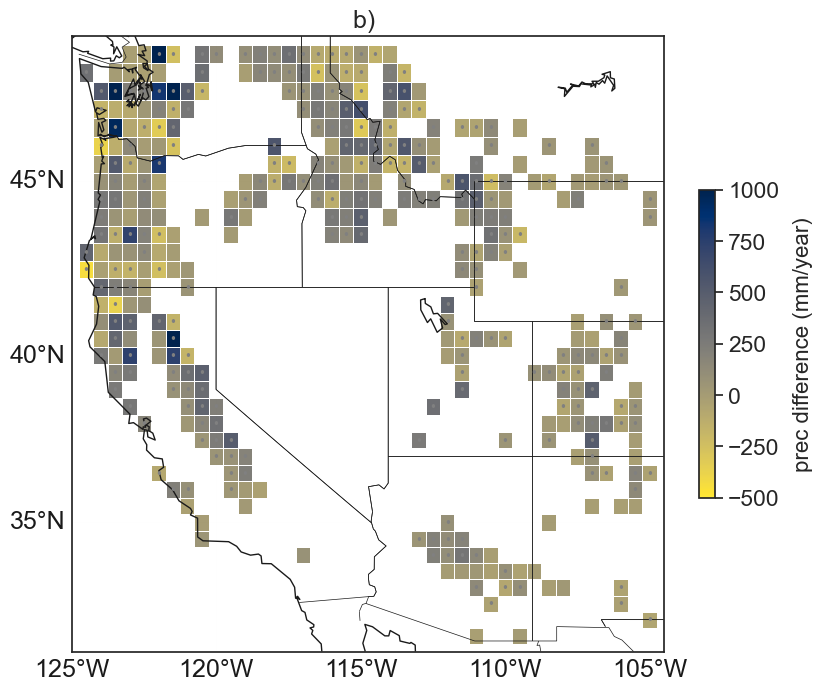

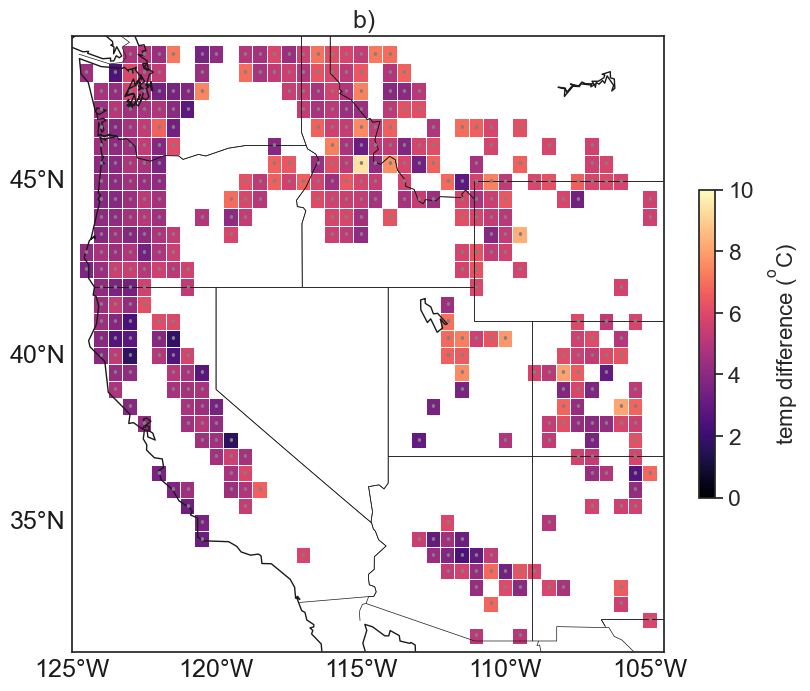

In [27]:
# Plot Map
def plot_figure(df, variable, colormap,color_range, figure_label, filename_and_path, title):
    lons = np.arange(-125, -104.5, 0.5)
    lats = np.arange(31, 49, 0.5)
    for lon in lons:
        for lat in lats:
            if not ((df["LON"] == lon) & (df["LAT"] == lat)).any():
                #df = df.append({"LON": lon, "LAT": lat, variable: -99999, "SIGNIFICANT": 0}, ignore_index=True)
                df = pd.concat([df, pd.DataFrame({"LON": lon, "LAT": lat, variable: [-99999],"SIGNIFICANT": 0})], ignore_index=True)

    # sort the data by longitude and latitude
    df = df.sort_values(by=["LON", "LAT"])

    # interpolate data to 0.25 by 0.25
    lon_new, lat_new = np.meshgrid(np.arange(-125, -104.5, 0.5), np.arange(31, 49, 0.5))
    z = griddata((df["LON"], df["LAT"]), df[variable], (lon_new, lat_new), method="linear")   
    
    
# plot the data using pcolormesh
    plt.figure(figsize=(23, 8))
    sns.set_theme(style="ticks", font="sans-serif", rc={"lines.linewidth": 2.5}, font_scale=1.5)
    m = Basemap(
        projection="mill",
        llcrnrlat=31,
        llcrnrlon=-125,
        urcrnrlat=49,
        urcrnrlon=-104.5,
        resolution="l",
    )
    m.drawcoastlines()
    m.drawcountries()
    m.drawstates()
    x, y = m(lon_new, lat_new)

    # set the color of grids with pct_diff == -99999 to white
    z_masked = np.ma.masked_where(z == -99999, z)
    m.pcolormesh(x, y, z_masked, cmap=colormap,edgecolor="white", linewidth=0.5)
    
    x_sig, y_sig = m(
        list(df[df["SIGNIFICANT"] == 1]["LON"]), list(df[df["SIGNIFICANT"] == 1]["LAT"])
    )

    m.scatter(
        x_sig,
        y_sig,
        c=df[df["SIGNIFICANT"] == 1][variable],
        s=50,
        cmap=colormap,
        marker=".",
        edgecolor="grey", facecolor="grey",
    )
    
        # plot the missing grids
    #for i, row in df.iterrows():
        #if row["SIGNIFICANT"] == 1:
           # x, y = m(row["LON"], row["LAT"])
            #plt.text(x, y, "•", fontsize=10, ha="center", va="center", color="grey")
        
    

    lat_interval = 5
    lon_interval = 5
    parallels = np.arange(25, 50, lat_interval)
    meridians = np.arange(-130, -104.5, lon_interval)
    m.drawparallels(
        parallels, labels=[True, False, False, False], linewidth=0.001
    )
    m.drawmeridians(
        meridians, labels=[False, False, False, True], linewidth=0.001
    )
    c = plt.colorbar(orientation="vertical", shrink=0.5, pad=0.02)
    c.set_label(
        label=figure_label,
        fontsize=16,
        labelpad=10,
    )
    c.ax.tick_params()
    plt.clim(color_range)
    plt.title(title)
    plt.savefig(filename_and_path, dpi=1200, format=image_format, bbox_inches="tight")
    plt.show()


plot_figure(
    precipitation_difference,
    "PRECIPITATION_DIFFERENCE",
    "cividis_r",
    (-500, 1000),
    "prec difference (mm/year)",
    "../figures/prec_diff_map." + image_format,
    "b) "
)


plot_figure(
    temperature_difference,
    "TEMPERATURE_DIFFERENCE",
    "magma",
    (0, 10),
    "temp difference ($\mathregular{^{o}}$C)",
    "../figures/tair_diff_map." + image_format,
    "b) "
)